In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab
import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
print('THIS IS A GLOBAL VARIABLE. Do not change testeq_GW')
global testeq_GW
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')

THIS IS A GLOBAL VARIABLE. Do not change testeq_GW


# generate a dataframe connecting directory with seq_name in their property df

In [5]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 188 ms, sys: 815 ms, total: 1 s
Wall time: 1.3 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


# write function

In [6]:
# def compute_3dplot_from_seq_name(seq_name):
#     example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
#     t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
#     t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
#     t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
#     t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
#     t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
#     protein_df = t_df_moments[['RSA']].copy()
#     del t_df_moments
#     protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
#     protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
#     protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
#     #plt.close()
#     return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [5]:
def get_grid_protein(seq_name):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    
    protein_rg2 = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_ree2 = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_ratio = protein_ree2/protein_rg2
    protein_rg_mean = np.mean(np.load(f'{example_protein_dir}/rg.npy'))
    protein_rg_by_rg_mean = np.load(f'{example_protein_dir}/rg.npy')/protein_rg_mean
    global grid_protein,grid_GW
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    x_total.append(protein_rg_by_rg_mean)
    y_total.append(protein_ratio)
    
    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    step_x=0.03#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=#(
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x+1)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y+1)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])
#    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])
    return

In [8]:
def compile_umap_df(provided_seq_list):
    j=0
    for provided_seq in provided_seq_list:
        if j==0:
            get_grid_protein(provided_seq)
            current_df = pd.DataFrame(grid_protein.flatten()).T
            current_df.columns=[f'box{box_lab}' for box_lab in range(grid_protein.flatten().shape[0])]
            current_df.insert(0,'peptID',provided_seq)
            master_df = current_df.copy()
        else:
            get_grid_protein(provided_seq)
            current_df = pd.DataFrame(grid_protein.flatten()).T
            current_df.columns=[f'box{box_lab}' for box_lab in range(grid_protein.flatten().shape[0])]
            current_df.insert(0,'peptID',provided_seq)
            master_df = pd.concat([master_df,current_df]).copy()
        j+=1
    return master_df

# get 2d conformation shape plot at different nu values (run in order, see j value in each cell) (ALL ~28000 sequences)

In [13]:
%%time
#do not run

all_seq_list = seq_name_dir_df['seq_name'].to_list()
master_df = compile_umap_df(all_seq_list).copy()

CPU times: user 1h 22min 4s, sys: 6min, total: 1h 28min 4s
Wall time: 1h 42min 54s


In [14]:
#do not run 
master_df = master_df.reset_index(drop=True)
master_df

,peptID,box0,box1,box2,box3,box4,box5,box6,box7,box8,...,box15,box16,box17,box18,box19,box20,box21,box22,box23,box24
0,H0YL14_1_46,93.0,33.0,0.0,0.0,0.0,220.0,129.0,2.0,0.0,...,45.0,129.0,5.0,0.0,0.0,3.0,15.0,1.0,0.0,0.0
1,H0YL09_1_131,139.0,40.0,1.0,0.0,0.0,231.0,124.0,4.0,0.0,...,40.0,100.0,3.0,0.0,0.0,3.0,7.0,2.0,0.0,0.0
2,H0YKK7_1_89,111.0,44.0,1.0,0.0,0.0,210.0,100.0,3.0,0.0,...,70.0,123.0,3.0,0.0,0.0,4.0,20.0,0.0,0.0,0.0
3,H0YKK7_135_164,95.0,25.0,0.0,0.0,0.0,228.0,98.0,1.0,0.0,...,58.0,144.0,1.0,0.0,0.0,3.0,25.0,0.0,0.0,0.0
4,H0YKK7_430_550,105.0,35.0,1.0,0.0,0.0,215.0,123.0,3.0,0.0,...,67.0,115.0,1.0,0.0,0.0,3.0,11.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,A3QJZ6_111_153,105.0,31.0,0.0,0.0,0.0,214.0,115.0,1.0,0.0,...,62.0,133.0,2.0,0.0,0.0,4.0,29.0,0.0,0.0,0.0
28054,A3QJZ7_106_152,123.0,52.0,0.0,0.0,0.0,227.0,112.0,2.0,0.0,...,59.0,111.0,3.0,0.0,0.0,2.0,17.0,0.0,0.0,0.0
28055,A3KN83_1001_1044,97.0,35.0,0.0,0.0,0.0,216.0,118.0,1.0,0.0,...,57.0,152.0,5.0,0.0,0.0,4.0,16.0,0.0,0.0,0.0
28056,A3KN83_1_250,106.0,37.0,1.0,0.0,0.0,213.0,119.0,5.0,0.0,...,60.0,91.0,7.0,0.0,0.0,3.0,8.0,0.0,0.0,0.0


In [15]:
master_df.to_csv('all_seq_box_df_smaller_box_size.csv')
master_df = pd.read_csv('all_seq_box_df_smaller_box_size.csv')
master_df = master_df.reset_index(drop=True)

In [16]:
idrome_prop_df = pd.read_csv('combined_idrome_prop_df.csv')
idrome_prop_df = pd.concat([master_df.set_index('peptID'),idrome_prop_df.set_index('seq_name')],axis=1)

In [17]:
idrome_prop_df['extra_nu_cat']=['<=0.45' if nu_<=0.45 else '>0.55' if nu_>0.55 else '>0.45 & <=0.55' for nu_ in idrome_prop_df.nu.values]

# normalize counts 

/home/hshadman/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


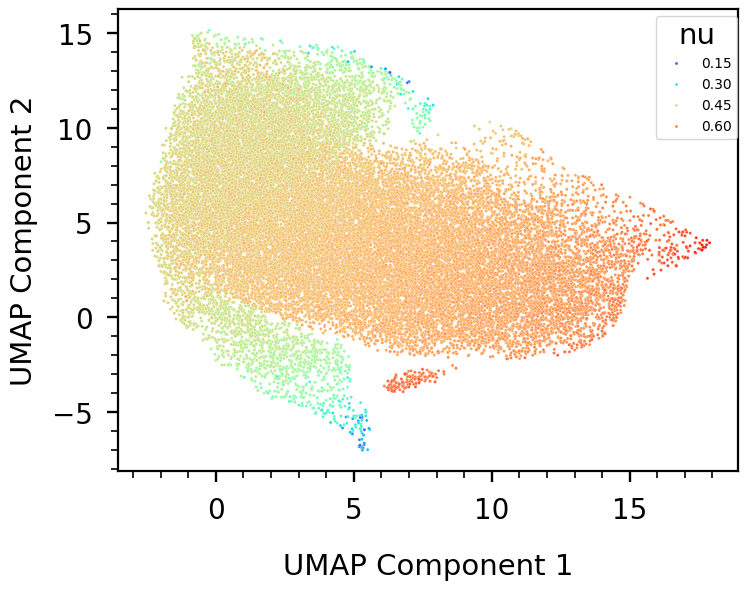

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))

features = idrome_prop_df[idrome_prop_df.columns[idrome_prop_df.columns.str.contains('box')]]
features = features.transform(lambda x: x/1000).copy()

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.8)
proj_2d = umap_2d.fit_transform(features)
# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=tcga_int.primary,labels={'color': 'primary'},
# )
# fig_2d.show()


sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1],hue=idrome_prop_df['nu'],palette='rainbow',s=5)
#ax.scatter(proj_2d[:,0], proj_2d[:,1])
ax.legend(title='nu', fontsize=10, bbox_to_anchor=(1.01,1)).get_title().set_fontsize(21)
ax.set_ylabel('UMAP Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('UMAP Component 1', fontsize=21, labelpad=20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)
# ax.set_ylim([-5,20])


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)

/home/hshadman/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


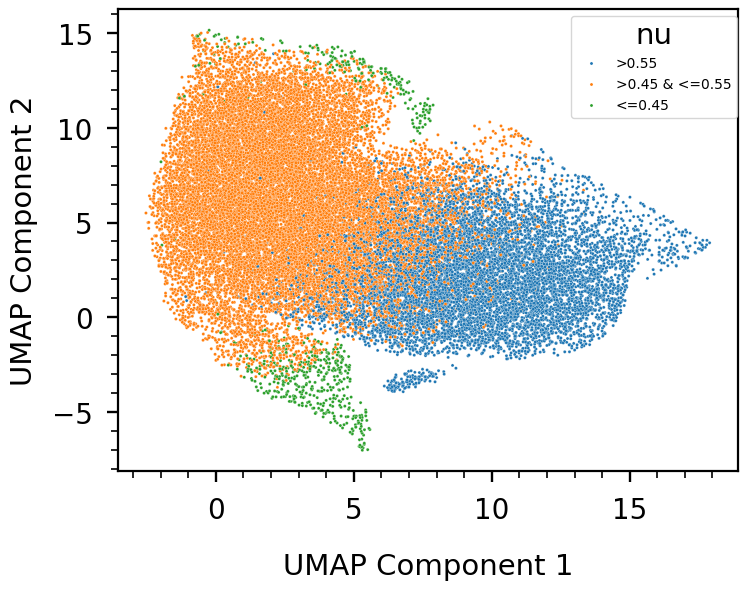

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))

features = idrome_prop_df[idrome_prop_df.columns[idrome_prop_df.columns.str.contains('box')]]
features = features.transform(lambda x: x/1000).copy()

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.8)
proj_2d = umap_2d.fit_transform(features)
# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=tcga_int.primary,labels={'color': 'primary'},
# )
# fig_2d.show()


sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1],hue=idrome_prop_df['extra_nu_cat'],palette='tab10',s=5)
#ax.scatter(proj_2d[:,0], proj_2d[:,1])
ax.legend(title='nu', fontsize=10, bbox_to_anchor=(1.01,1)).get_title().set_fontsize(21)
ax.set_ylabel('UMAP Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('UMAP Component 1', fontsize=21, labelpad=20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)
# ax.set_ylim([-5,20])


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)

# function for pyconformap shape vs size

In [55]:
exec(open("pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 